In [1]:
import collections
import math
import os
import errno
import random
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from keras import backend as K

#Clear TF memory
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

C:\Users\StrikeWade\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Get the words zip file data

In [2]:
data_dir = 'word2vec_data/words'
data_url = 'http://mattmahoney.net/dc/text8.zip'

In [3]:
def fetch_words_data(url=data_url, words_data=data_dir):
    
    #Make the dir if it does not exist
    os.makedirs(words_data, exist_ok=True)
    
    #Path to zip file
    zip_path = os.path.join(words_data, 'words.zip')
    
    #If the zip file isnt there, download it form the data url
    if not os.path.exists(zip_path):
        urllib.request.urlretrieve(url, zip_path)
        
    #Now that the zip file is there, get the data from it
    with zipfile.ZipFile(zip_path) as f:
        data = f.read(f.namelist()[0])
        
    #Return a list of all the words in the data source
    return data.decode('ascii').split()

In [4]:
words = fetch_words_data()

In [5]:
print(len(words))
print(words[7000:7040])

17005207
['org', 'wikipedia', 'page', 'industrial', 'workers', 'of', 'the', 'world', 'anarchism', 'forms', 'of', 'government', 'political', 'ideology', 'entry', 'points', 'political', 'theories', 'social', 'philosophy', 'autism', 'is', 'classified', 'as', 'a', 'neurodevelopmental', 'disorder', 'that', 'manifests', 'itself', 'in', 'markedly', 'abnormal', 'social', 'interaction', 'communication', 'ability', 'patterns', 'of', 'interests']


In [6]:
for w in words[7000:7040]:
    print(w, end=' ')

org wikipedia page industrial workers of the world anarchism forms of government political ideology entry points political theories social philosophy autism is classified as a neurodevelopmental disorder that manifests itself in markedly abnormal social interaction communication ability patterns of interests 

In [7]:
from collections import Counter

In [8]:
my_list_example = ['one','two','two']
Counter(my_list_example).most_common()

[('two', 2), ('one', 1)]

# Create vocabulary list

In [9]:
def create_counts(vocab_size = 50000):
    
    #Choose a list of 50000 most common words as vocabulary
    vocab = [] + Counter(words).most_common(vocab_size)
#     print(vocab)
    
    #Create an array of most common words from the tuple (does not need the count)
    vocab = np.array([word for word, _ in vocab])
    print('50000 most common word list: ',vocab)
    
    dictionary = {word:code for code, word in enumerate(vocab)}
    print('A dictionary - word:enumerate_number :', dictionary)
    
    data = np.array([dictionary.get(word,0) for word in words])
    print('A list of enumerate_number of 17005207 words: ', data)
    
    return data, vocab

In [10]:
data, vocabulary = create_counts()

50000 most common word list:  ['the' 'of' 'and' ... 'berglin' 'transwomen' 'unscr']
A dictionary - word:enumerate_number : {'impassable': 33351, 'gaetano': 34357, 'eplf': 24052, 'special': 465, 'attaining': 17988, 'cartoon': 4039, 'establishment': 2509, 'import': 1840, 'hispanics': 40172, 'pva': 44093, 'freescale': 32601, 'glaciers': 8063, 'canaan': 12159, 'stocked': 35828, 'erythematosus': 38934, 'motivations': 15269, 'becomes': 802, 'tribulations': 44611, 'protease': 29372, 'charged': 2766, 'precaution': 24623, 'fiorentina': 30964, 'joshi': 25097, 'munro': 28128, 'toed': 24405, 'wednesday': 13112, 'ribs': 22072, 'quadrature': 42432, 'hippocrates': 23434, 'unfavourable': 27016, 'espouse': 39363, 'compulsion': 35778, 'upn': 25242, 'mysore': 18780, 'patrolling': 33353, 'cheap': 6644, 'dirk': 14989, 'drier': 22602, 'carnivora': 26055, 'kramnik': 33571, 'consulates': 22237, 'sons': 2111, 'chileans': 30546, 'goyen': 47134, 'noir': 7994, 'crazed': 29373, 'introduce': 5896, 'sweeping': 10876

In [11]:
print(data.shape)
print(data)

(17005207,)
[5243 3082   11 ...   21   15   72]


In [12]:
print(vocabulary.shape)
print(vocabulary[np.random.randint(0,50000)])

(50000,)
discrete


In [13]:
print('The specific word: "%s", Index: %s' % (words[100], data[100]))

The specific word: "interpretations", Index: 4188


# Generate batch function

In [14]:
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    if data_index + span > len(data):
        data_index = 0
    buffer.extend(data[data_index:data_index + span])
    data_index += span
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
    if data_index == len(data):
        buffer[:] = data[:span]
        data_index = span
    else:
        buffer.append(data[data_index])
        data_index += 1
  # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels

In [15]:
#Constant
batch_size = 128
embedding_size = 150

skip_window = 1 #How many words to consider to the left and to the right - bigger the value, the longer training
num_skips = 2 #How many times to reuse an input to generate a label

valid_size = 16 #Random set of words to evaluate similarity and then pich samples
valid_window = 100
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

In [16]:
np.random.choice(valid_window, valid_size, replace=False)

array([32, 17, 26, 92,  1, 68, 41, 83, 10, 72, 43, 61, 12,  9, 35, 31])

In [17]:
num_sampled = 64
learning_rate = 0.01
vocabulary_size = 50000

In [18]:
tf.reset_default_graph()

In [19]:
train_inputs = tf.placeholder(dtype=tf.int32, shape=[None])
train_labels = tf.placeholder(dtype=tf.int32, shape=[batch_size, 1])

valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

In [20]:
init_embeds = tf.random_uniform(shape=[vocabulary_size, embedding_size], minval=-1.0, maxval=1.0)

In [21]:
embeddings = tf.Variable(init_embeds)

In [22]:
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

In [23]:
# nce weights
nce_weights = tf.Variable(tf.truncated_normal(shape=[vocabulary_size, embedding_size], stddev=1.0/np.sqrt(embedding_size)))
# nce biases
nce_biases = tf.Variable(tf.zeros(shape=[vocabulary_size]))

In [24]:
#loss
loss = tf.reduce_mean(tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed, num_sampled, vocabulary_size))

In [25]:
optimizer = tf.train.AdamOptimizer(learning_rate=1.0).minimize(loss)

In [26]:
# Compute the cosine similarity between minibatch examples and all embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [27]:
data_index = 0
init = tf.global_variables_initializer()

In [28]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)

In [29]:
# Usually needs to be quite large to get good results, 
# training takes a long time!
epochs = 100001

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)
    avg_loss = 0
    
    for epoch in range(epochs):
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        
        _, loss_val = sess.run([optimizer, loss], feed_dict={train_inputs: batch_inputs, train_labels: batch_labels})
        
        avg_loss += loss_val
        
        if epoch % 1000 == 0:
            if epoch > 0:
                avg_loss = avg_loss/1000
            print('Average loss at epoch', epoch, 'is: ', avg_loss)
            avg_loss = 0
            
        final_embeddings = normalized_embeddings.eval()

Average loss at epoch 0 is:  277.3104248046875
Average loss at epoch 1000 is:  10323.420187332153
Average loss at epoch 2000 is:  23134.178189117432
Average loss at epoch 3000 is:  26157.368648780823
Average loss at epoch 4000 is:  30191.228290161132
Average loss at epoch 5000 is:  35739.2077131958
Average loss at epoch 6000 is:  39418.90880129242
Average loss at epoch 7000 is:  38807.21808683387
Average loss at epoch 8000 is:  43741.24781509891
Average loss at epoch 9000 is:  44480.89900127983
Average loss at epoch 10000 is:  46226.03472562268
Average loss at epoch 11000 is:  44421.21418155098
Average loss at epoch 12000 is:  49185.62105365674
Average loss at epoch 13000 is:  47902.14326307362
Average loss at epoch 14000 is:  43316.897698928835
Average loss at epoch 15000 is:  43738.203479878604
Average loss at epoch 16000 is:  46891.411744361874
Average loss at epoch 17000 is:  40496.440237596995
Average loss at epoch 18000 is:  43182.5157328186
Average loss at epoch 19000 is:  44476

In [30]:
final_embeddings.shape

(50000, 150)

In [31]:
from sklearn.manifold import TSNE

In [32]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)

In [33]:
plot_only = 500 #Plot only 500 words

In [34]:
low_dim_embed = tsne.fit_transform(final_embeddings[:plot_only, :])

In [35]:
#The coordinate x, y on the plot figure
low_dim_embed.shape

(500, 2)

In [36]:
labels = [vocabulary[i] for i in range(plot_only)]

In [37]:
import matplotlib.cm as cm

def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    
    plt.figure(figsize=(18,18))
    
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label, xy=(x,y), xytext=(5,2), textcoords='offset points', ha='right', va='bottom')

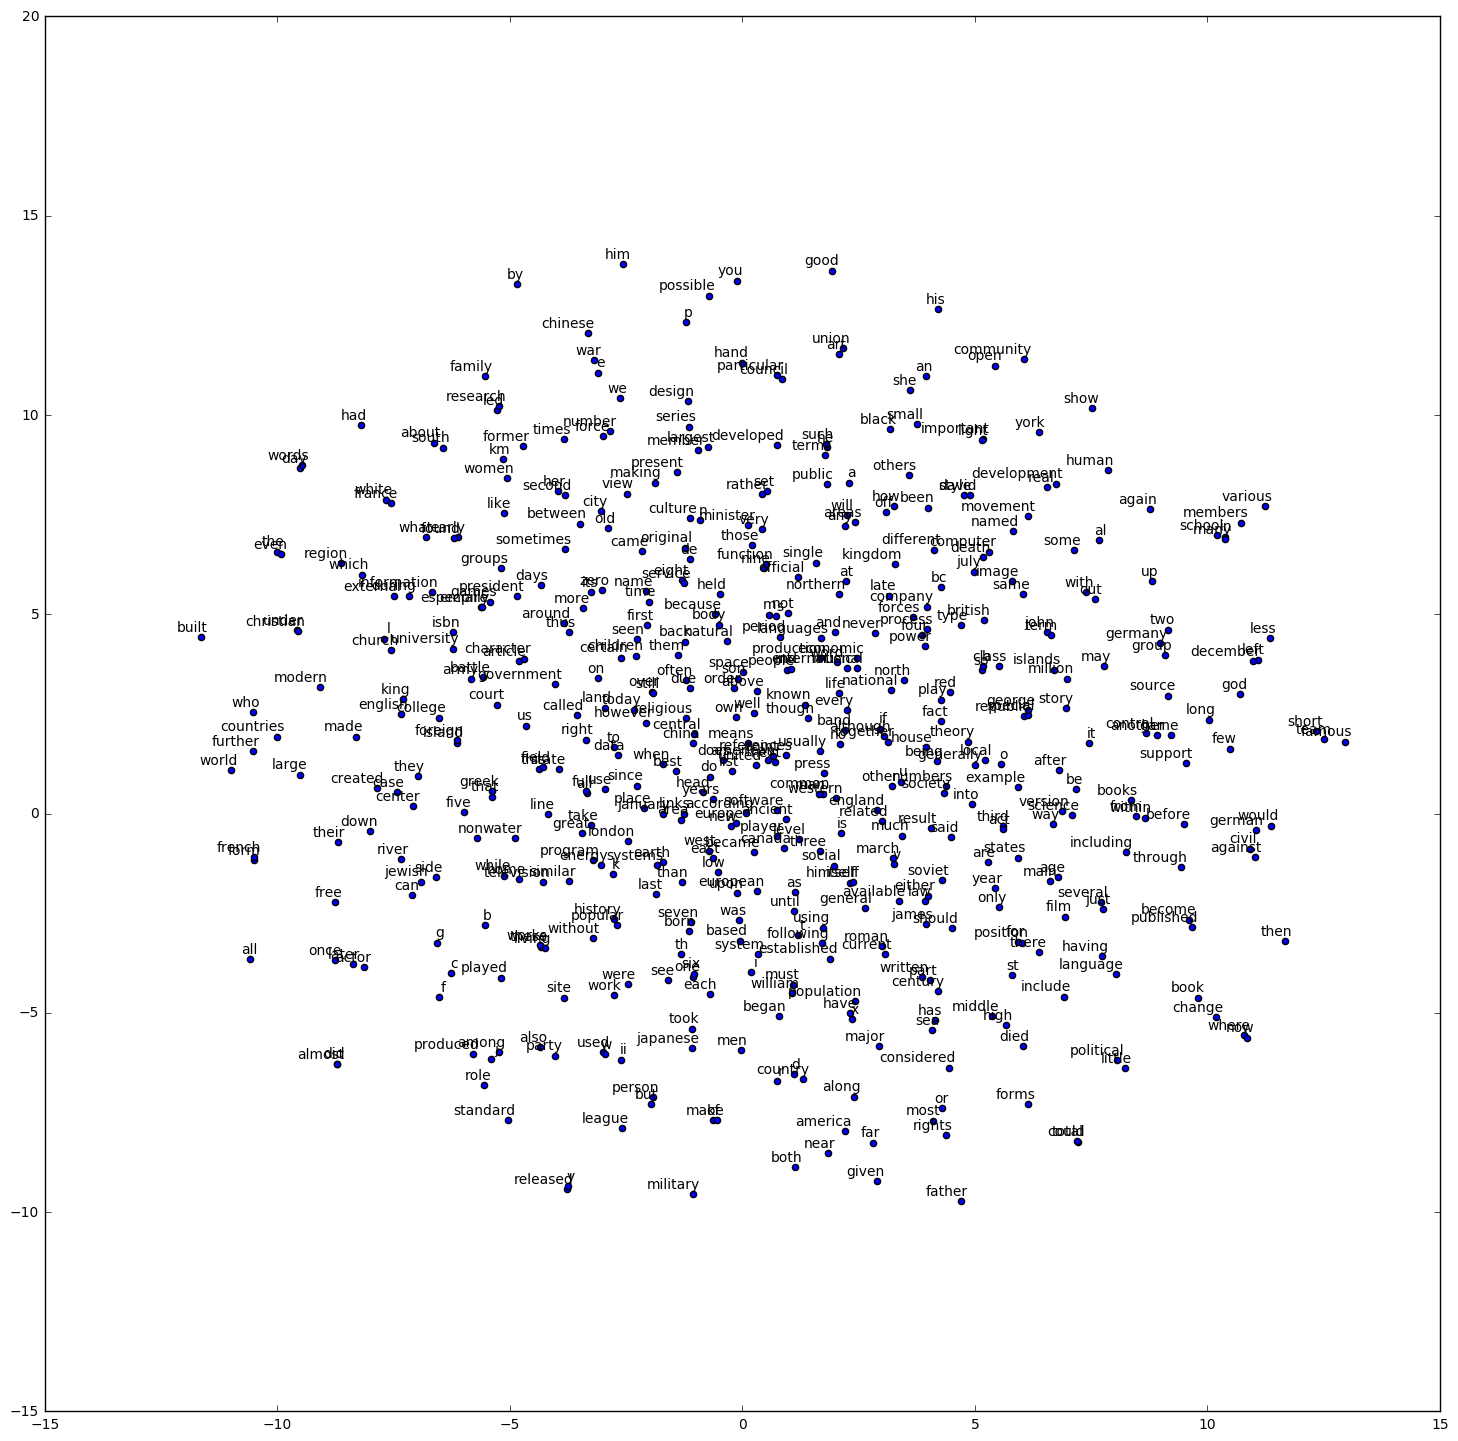

In [38]:
plot_with_labels(low_dim_embed, labels)